In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import os
import sys
from tqdm import tqdm

sys.path.append('../../ieegpy/ieeg')
sys.path.append('code/tools')
sys.path.append('code')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# sets path to one directory up from where code is
path = "/".join(os.path.abspath(os.getcwd()).split('/')[:-1])

import json
import numpy as np
import pandas as pd
from get_iEEG_data import get_iEEG_data
from plot_iEEG_data import plot_iEEG_data
from line_length import line_length
from get_iEEG_duration import get_iEEG_duration
import csv_utils
import segmentation
import feature_extraction

In [75]:
with open("credentials.json") as f:
    credentials = json.load(f)
    username = credentials['username']
    password = credentials['password']

iEEG_filename = "HUP172_phaseII"
start_time_usec = 402580 * 1e6
stop_time_usec = 402800 * 1e6
electrodes = ["LE10", "LE11", "LH01", "LH02", "LH03", "LH04"]

In [76]:
data, fs = get_iEEG_data(username, password, iEEG_filename, start_time_usec, stop_time_usec,
                         select_electrodes=electrodes)
t_sec = np.linspace(start_time_usec, stop_time_usec, num=data.shape[0]) / 1e6

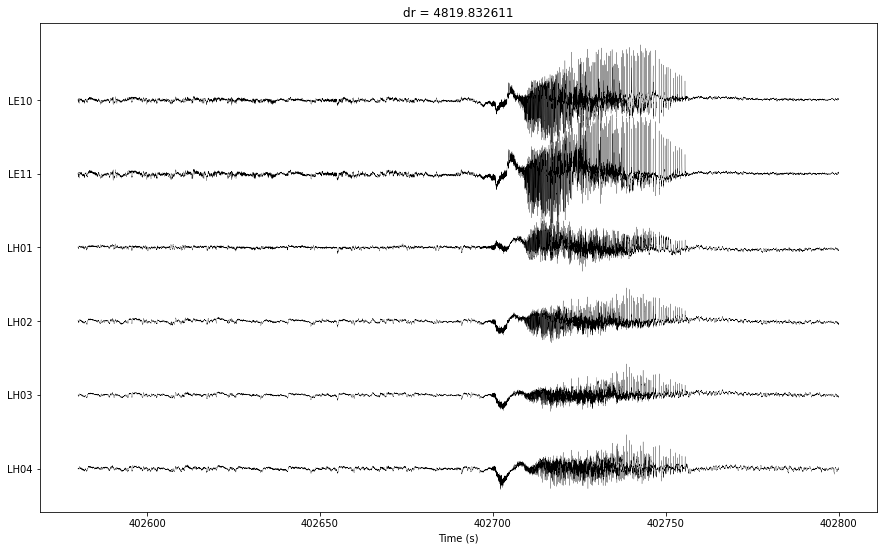

In [77]:
plot_iEEG_data(data, t_sec)

Text(0.5, 0, 'Clip Time (sec)')

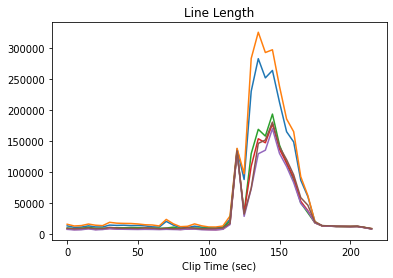

In [78]:
win_size_sec = 5

win_size_ind = int(win_size_sec * fs)

start_range = np.arange(0, len(data), win_size_ind, dtype=int)

ll_arr = np.zeros((len(start_range), data.shape[1]))
for i, start_ind in enumerate(start_range):
    ll_arr[i] = line_length(data[start_ind:(start_ind + win_size_ind)])

fig, ax = plt.subplots()
ax.plot(start_range / fs, ll_arr)
ax.set_title("Line Length")
ax.set_xlabel("Clip Time (sec)")

In [79]:
metadata = pd.read_csv('ieeg_metadata.csv')
metadata.describe()

,Unnamed: 0,Seizure number,Seizure EEC,Seizure UEO,Seizure end,Seizure duration
count,256.000000,256.000000,2.560000e+02,2.560000e+02,2.560000e+02,256.000000
mean,161.523438,3.808594,3.850046e+05,3.850087e+05,3.850987e+05,89.983726
std,105.468253,4.411047,2.512188e+05,2.512184e+05,2.512276e+05,107.030035
min,0.000000,0.000000,1.422600e+04,1.422600e+04,1.425995e+04,4.900000
25%,64.750000,1.000000,2.076900e+05,2.076916e+05,2.077277e+05,34.252500
50%,155.500000,2.000000,3.487700e+05,3.487708e+05,3.490025e+05,67.945000
75%,255.250000,5.000000,5.301436e+05,5.301436e+05,5.302733e+05,91.760000
max,364.000000,22.000000,1.694568e+06,1.694570e+06,1.694644e+06,781.950000


In [80]:
seizure_data = csv_utils.read_pickle('data/seizure/seizure_clips_data', 150)
seizure_time = csv_utils.read_pickle('data/seizure_time/seizure_time_data', 150)
for i in range(len(seizure_data)):
    seizure_data[i] = seizure_data[i].dropna(axis='columns')

In [81]:
nonseizure_data = csv_utils.read_pickle('data/non_seizure/nonseizure_clips_data', 150)
nonseizure_time = csv_utils.read_pickle('data/non_seizure_time/nonseizure_time_data', 150)
for i in range(len(nonseizure_data)):
    nonseizure_data[i] = nonseizure_data[i].dropna(axis='columns')

In [ ]:
# seizure_data,seizure_time = csv_utils.seizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(seizure_data,'data/seizure/seizure_clips_data')
# csv_utils.dump_pickle(seizure_time,'data/seizure_time/seizure_time_data')

In [ ]:
# nonseizure_data, nonseizure_time = csv_utils.nonseizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(nonseizure_data,'data/non_seizure/nonseizure_clips_data')
# csv_utils.dump_pickle(nonseizure_time,'data/non_seizure_time/nonseizure_time_data')

In [82]:
window_len = 2
stride = 1
seizure_data_windowed = []
for i in tqdm(range(len(seizure_data))):
    fs = segmentation.get_fs(seizure_time[i])
    print(fs)
    seg = segmentation.get_windoweds(seizure_data[i].to_numpy(), fs, window_len, stride)
    seizure_data_windowed.append(seg)
window_len = 2
stride = 1
nonseizure_data_windowed = []
for i in tqdm(range(len(nonseizure_data))):
    fs = segmentation.get_fs(nonseizure_time[i])
    seg = segmentation.get_windoweds(nonseizure_data[i].to_numpy(), fs, window_len, stride)
    nonseizure_data_windowed.append(seg)

  3%|▎         | 4/150 [00:00<00:04, 29.93it/s]

500
500
500
512
512
512
512


  8%|▊         | 12/150 [00:00<00:04, 30.54it/s]

512
512
512
512
512
512
512
512
512
512
512
512
512
512


 17%|█▋        | 25/150 [00:00<00:01, 63.25it/s]

512
512
512
512
512
512
512
512
512
512


 21%|██▏       | 32/150 [00:01<00:04, 27.47it/s]

512
512
512
512
512
512


 27%|██▋       | 41/150 [00:01<00:04, 22.14it/s]

512
512
512
512
512
512
512


 30%|███       | 45/150 [00:02<00:08, 12.49it/s]

512
512


 37%|███▋      | 56/150 [00:02<00:05, 18.18it/s]

512
512
512
512
512
512
512
512
512
512


 41%|████      | 61/150 [00:02<00:04, 21.15it/s]

512
512
512
512
512
512
512
512


 43%|████▎     | 65/150 [00:03<00:03, 23.07it/s]

512
512
512
512
512


 49%|████▊     | 73/150 [00:03<00:03, 25.27it/s]

512
512
500
500
500
500


 51%|█████▏    | 77/150 [00:03<00:03, 20.25it/s]

512
512
512
500
500
500


 55%|█████▍    | 82/150 [00:03<00:02, 24.39it/s]

500
500
500
500


 59%|█████▉    | 89/150 [00:04<00:02, 22.76it/s]

500
500
500
500
500
500


 70%|███████   | 105/150 [00:04<00:01, 40.81it/s]

500
500
500
500
500
500
500
500
500
500
500
500
500
500


 73%|███████▎  | 110/150 [00:04<00:01, 37.51it/s]

500
500
500
500
500
500
500
500
1024
1024


 77%|███████▋  | 115/150 [00:13<00:18,  1.94it/s]

1024
1024
1024


 79%|███████▊  | 118/150 [00:16<00:19,  1.64it/s]

1024
1024
1024


 81%|████████  | 121/150 [00:21<00:24,  1.20it/s]

1024


 84%|████████▍ | 126/150 [00:22<00:14,  1.66it/s]

512
512
512
512
512
512
512
512


 87%|████████▋ | 131/150 [00:22<00:07,  2.66it/s]

512
1024
512
512


 89%|████████▉ | 134/150 [00:23<00:04,  3.30it/s]

1024
1024
1024


 91%|█████████▏| 137/150 [00:23<00:03,  3.68it/s]

1024
1024


 94%|█████████▍| 141/150 [00:24<00:02,  3.95it/s]

1024
1024
1024
1024


 95%|█████████▌| 143/150 [00:26<00:03,  2.29it/s]

512


 96%|█████████▌| 144/150 [00:27<00:02,  2.44it/s]

512


 97%|█████████▋| 145/150 [00:27<00:02,  2.47it/s]

512


 97%|█████████▋| 146/150 [00:27<00:01,  2.69it/s]

512


 98%|█████████▊| 147/150 [00:28<00:01,  1.96it/s]

512


 99%|█████████▊| 148/150 [00:29<00:00,  2.06it/s]

512


100%|██████████| 150/150 [00:29<00:00,  5.09it/s]


512


100%|██████████| 150/150 [00:24<00:00,  6.04it/s]


In [83]:
seizure_data_features = []
for i, clip in tqdm(enumerate(seizure_data_windowed)):
    fs = segmentation.get_fs(seizure_time[i])
    f1 = feature_extraction.calculate_line_length(clip)
    f2 = feature_extraction.calculate_area(clip)
    f3 = feature_extraction.calculate_energy(clip)
    f4 = feature_extraction.avg_frequency_mag(clip)
    f5 = feature_extraction.hjorthActivity(clip)
    f6 = feature_extraction.hjorthComplexity(clip)
    f7 = feature_extraction.hjorthMobility(clip)
    f8 = np.transpose(feature_extraction.freqFeatures(clip, fs=fs), [1, 0, 2])
    f = np.array([f1, f2, f3, f4])
    f = np.vstack((f, f8))
    f = np.transpose(f,[1,2,0])
    f_exam = f
    if np.isinf(f_exam).any() or np.isnan(f_exam).any():
        print('nan of inf')
    seizure_data_features.append(f)

12it [00:18,  1.43s/it]code\feature_extraction.py:142: RuntimeWarning: invalid value encountered in true_divide
  q = var_gred / var
150it [05:09,  2.07s/it]


In [84]:
nonseizure_data_features = []
for i, clip in tqdm(enumerate(nonseizure_data_windowed)):
    fs = segmentation.get_fs(nonseizure_time[i])
    try:
        f1 = feature_extraction.calculate_line_length(clip)
        f2 = feature_extraction.calculate_area(clip)
        f3 = feature_extraction.calculate_energy(clip)
        f4 = feature_extraction.avg_frequency_mag(clip)
        f5 = feature_extraction.hjorthActivity(clip)
        f6 = feature_extraction.hjorthComplexity(clip)
        f7 = feature_extraction.hjorthMobility(clip)
        f8 = np.transpose(feature_extraction.freqFeatures(clip, fs=fs), [1, 0, 2])
        f = np.array([f1, f2, f3, f4])
        f = np.vstack((f, f8))
        f = np.transpose(f,[1,2,0])
        f_exam = f
        if np.isinf(f_exam).any() or np.isnan(f_exam).any():
            print('nan of inf')
        nonseizure_data_features.append(f)
    except:
        print("ignore 1")

150it [02:07,  1.17it/s]


In [ ]:
seizure_data_features_flatten = np.empty((0,11))
for i, clip in enumerate(seizure_data_features):
    seizure_data_features_flatten = np.vstack((seizure_data_features_flatten,clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2]))))

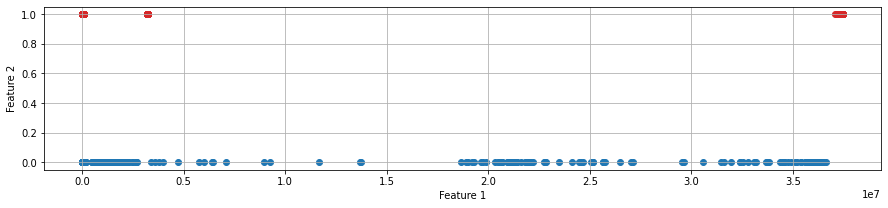

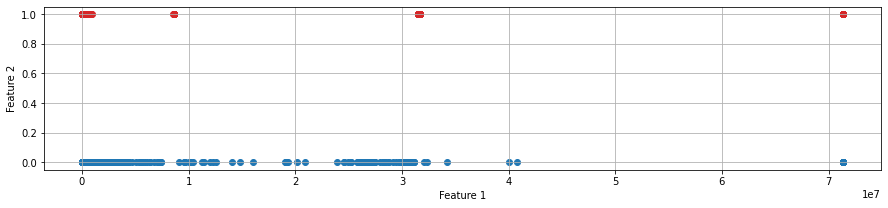

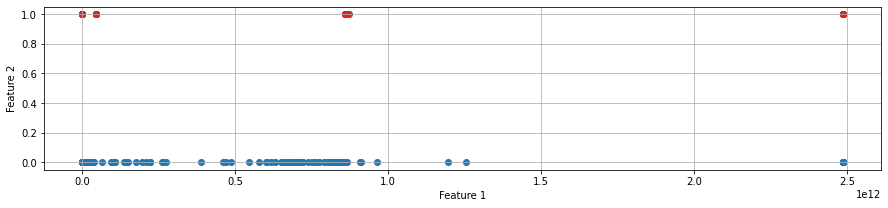

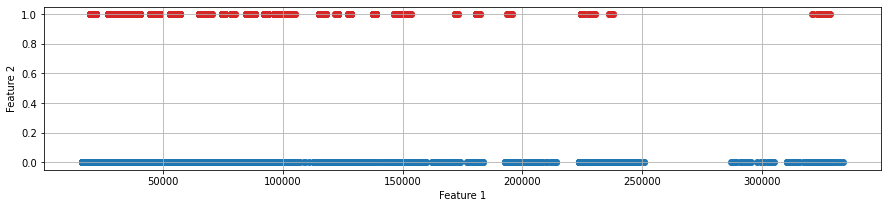

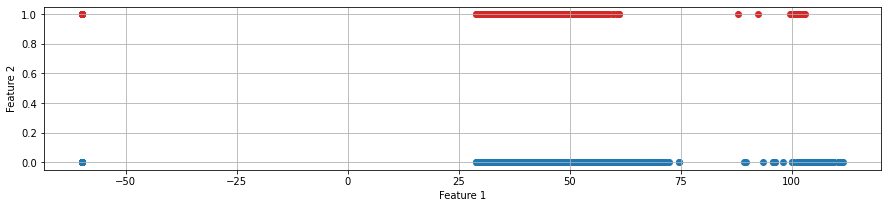

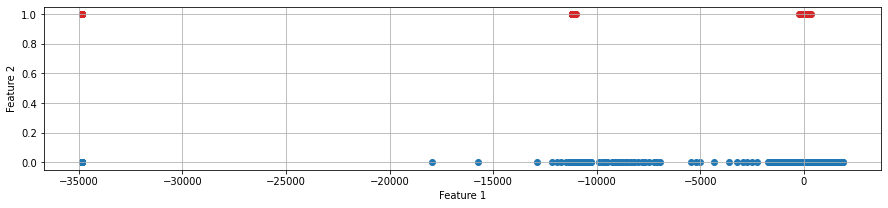

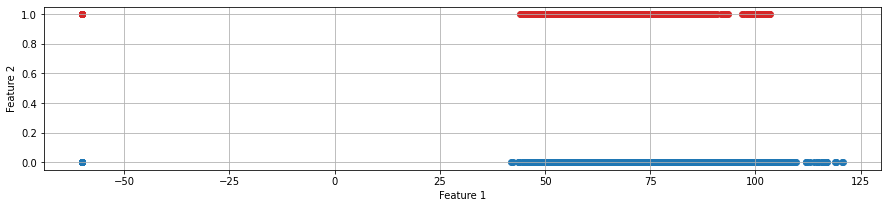

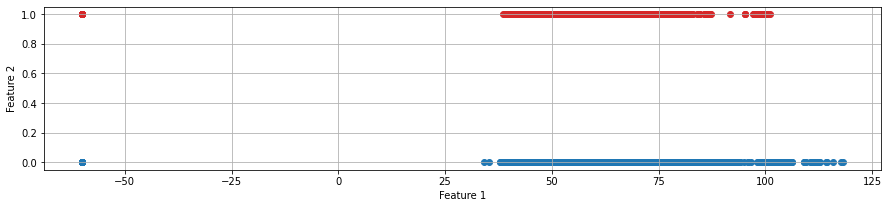

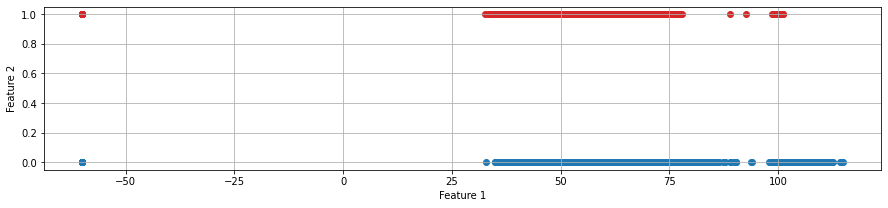

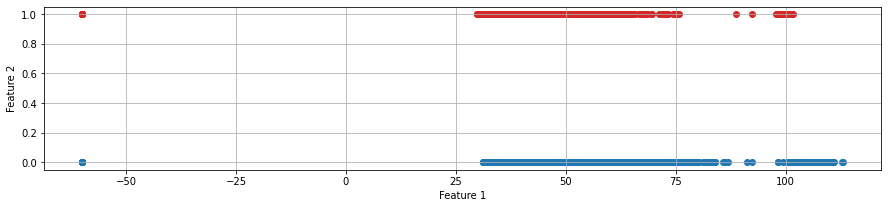

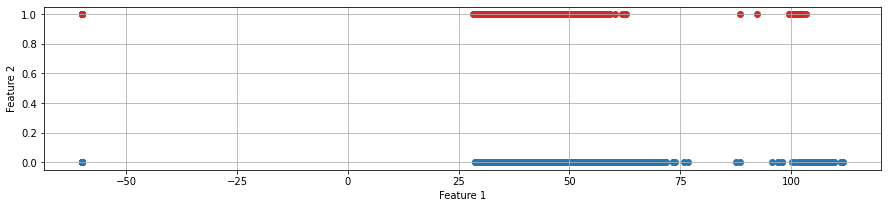

In [119]:
for i in range(11):
    plt.figure(figsize=(15, 3))
    clip = seizure_data_features[137]
    plt.scatter(clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2]))[:,i],np.zeros((clip.shape[0]*clip.shape[1], clip.shape[2]))[:,0],color='tab:blue')
    clip = nonseizure_data_features[137]
    plt.scatter(clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2]))[:,i],np.ones((clip.shape[0]*clip.shape[1], clip.shape[2]))[:,4],color='tab:red')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(zorder = 4)
    plt.show()

In [87]:
nonseizure_data_features[0].shape

(49, 59, 11)

In [ ]:
nonseizure_data_features_flatten = np.empty((0,11))
for i, clip in enumerate(nonseizure_data_features):
    nonseizure_data_features_flatten = np.vstack((nonseizure_data_features_flatten,clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2]))))

In [ ]:
pca_seizure = PCA()
seizure_reduced = pca_seizure.fit_transform(seizure_data_features_flatten)

In [ ]:
pca_nonseizure = PCA()
nonseizure_reduced = pca_nonseizure.fit_transform(nonseizure_data_features_flatten)

In [ ]:
seizure_reduced[:,0]

In [ ]:
colortable = {}


In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(seizure_reduced[:,1],seizure_reduced[:,2],color='tab:blue')
plt.scatter(nonseizure_reduced[:,1],nonseizure_reduced[:,2],color='tab:red')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(zorder = 4)
plt.show()

In [ ]:
ev_seizure = pca_seizure.explained_variance_
ev_nonseizure = pca_nonseizure.explained_variance_

In [ ]:
ev = ev_nonseizure
bar_x = np.linspace(0,11,11)
cum_pv = np.cumsum(ev)/np.sum(ev)*100

fig,ax = plt.subplots(figsize=(15, 8))
ax.bar(bar_x,ev, color ='tab:blue',width = 0.4)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Cummulative Variance")
ax.set_title("PCs and Variance Explained for the first 20 PCs")
ax2 = ax.twinx()

ax2.plot(cum_pv,'-o',color = 'tab:red')
ax2.set_ylabel("Variance Explained Explained [%]")
ax2.grid()
fig.tight_layout()


plt.show()

In [ ]:
ev

In [16]:
seizure_data_features_flatten = np.empty((0,11))
for i, clip in enumerate(seizure_data_features):
    seizure_data_features_flatten = np.vstack((seizure_data_features_flatten,clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2]))))

In [17]:
nonseizure_data_features_flatten = np.empty((0,11))
for i, clip in enumerate(nonseizure_data_features):
    nonseizure_data_features_flatten = np.vstack((nonseizure_data_features_flatten,clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2]))))

In [18]:
pca_seizure = PCA()
seizure_reduced = pca_seizure.fit_transform(seizure_data_features_flatten)

In [19]:
pca_nonseizure = PCA()
nonseizure_reduced = pca_nonseizure.fit_transform(nonseizure_data_features_flatten)

In [25]:
seizure_reduced[:,0]

array([-5.12383420e+09,  9.63043990e+09,  3.78903481e+10, ...,
       -1.00038121e+10, -9.98798371e+09, -9.57959762e+09])

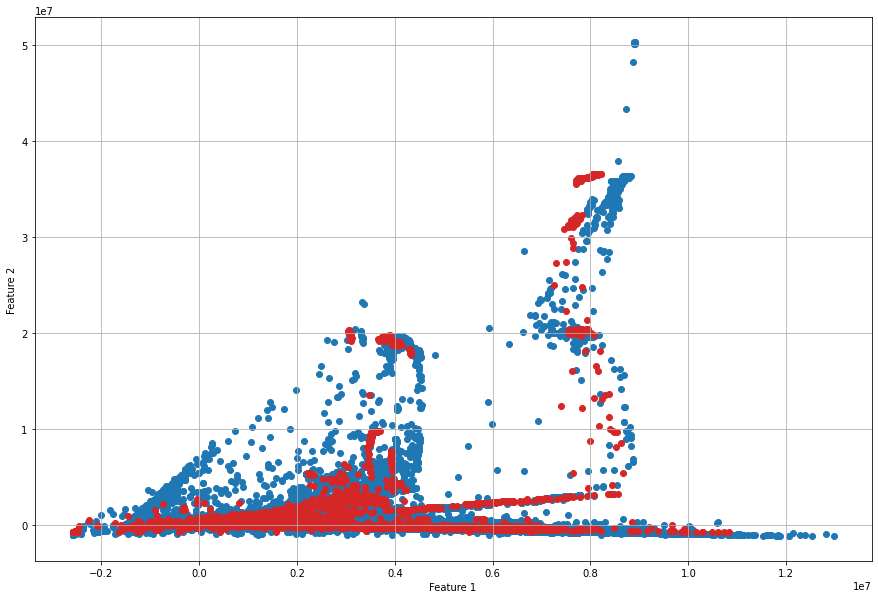

In [27]:
plt.figure(figsize=(15, 10))
plt.scatter(seizure_reduced[:,1],seizure_reduced[:,2],color='tab:blue')
plt.scatter(nonseizure_reduced[:,1],nonseizure_reduced[:,2],color='tab:red')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(zorder = 4)
plt.show()

In [22]:
ev_seizure = pca_seizure.explained_variance_
ev_nonseizure = pca_nonseizure.explained_variance_

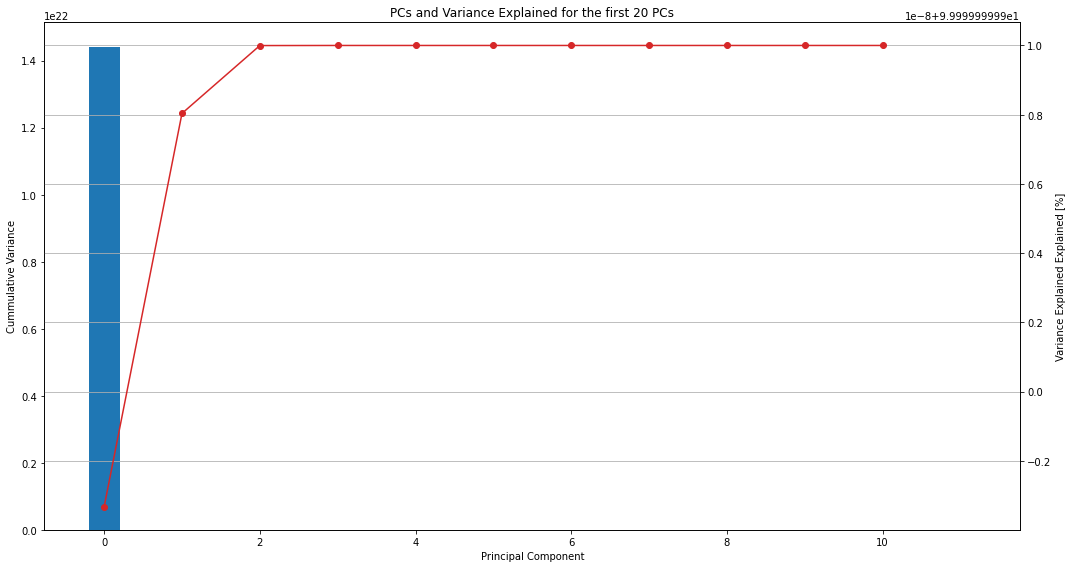

In [23]:
ev = ev_nonseizure
bar_x = np.linspace(0,11,11)
cum_pv = np.cumsum(ev)/np.sum(ev)*100

fig,ax = plt.subplots(figsize=(15, 8))
ax.bar(bar_x,ev, color ='tab:blue',width = 0.4)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Cummulative Variance")
ax.set_title("PCs and Variance Explained for the first 20 PCs")
ax2 = ax.twinx()

ax2.plot(cum_pv,'-o',color = 'tab:red')
ax2.set_ylabel("Variance Explained Explained [%]")
ax2.grid()
fig.tight_layout()


plt.show()

In [24]:
ev

array([1.44209057e+22, 1.63844749e+12, 2.82633153e+11, 3.91088938e+08,
       2.82630045e+06, 1.97805224e+02, 3.41355554e+01, 9.89466230e+00,
       4.20546918e+00, 2.84140091e+00, 9.31363544e-01])